In [11]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [26]:
#Propotional Navigation
N = 3
def update_accel(target,missile,Ngain):    
    R = (target[0:3,0] - missile[0:3,0]).reshape((3,1))
    Vr = (target[3:,0] - missile[3:,0]).reshape((3,1))
    Omega = np.cross(R,Vr,axis = 0)/(R.T@R)
    a = N*np.cross(Vr,Omega,axis=0)
    return a

In [27]:
pi = np.pi
dt = .1    


pos_var0 = 500 
max_plane_vel = 1553*1609.34/3600     
plane_vel = 840*1609.34/3600        

# initial true state of plane
plane_true_state = np.array([[10000, 0, 10000, 0, plane_vel, 0]]).T
a_plane = np.zeros((3,1))

# 99% sure the plane is is within the max speed
# abs(max_speed) is within 3 std 
vel_var0 = (max_plane_vel/3)**2

# 99% sure accel due to windspeed is within 20 m/s^2
accel_var = (20/3)**2  

#noise in sensor
sensor_var = 25  


In [28]:
# define params and initial conditions for missile
missile_range = 70000 
a_missile = np.zeros((3,1))
missile_range = 70000 
missile_vel = 2.8*343

#States x,y,x, vx, vy, vz
missile_state = np.array([[0,0,0,missile_vel*np.sin(pi/4)*np.cos(pi/4),
                     missile_vel*np.sin(pi/4)*np.sin(pi/4),
                     missile_vel*np.cos(pi/4),]]).T



In [29]:
#setting up matrices for prediction and update steps
pi = np.pi
dt = .1    #10hz
#State Transition Function
A = np.array([[1, 0, 0, dt, 0 ,0],
              [0, 1, 0, 0, dt, 0],
              [0, 0, 1, 0, 0, dt],
              [0, 0, 0, 1, 0 ,0 ], 
              [0, 0, 0, 0, 1 , 0],
              [0, 0, 0, 0, 0,1]])
B = np.array([[.5*dt**2, 0, 0],
              [0, .5*dt**2, 0],
              [0, 0, .5*dt**2],
              [dt, 0, 0], 
              [0, dt, 0],
              [0, 0, dt]])
#State Covariance
P = np.array([[pos_var0, 0,0,0,0,0],
              [0, pos_var0,0,0,0,0],
              [0, 0,pos_var0,0,0,0],
              [0, 0,0,vel_var0,0,0],
              [0, 0,0,0,vel_var0,0],
              [0, 0,0,0,0,vel_var0],])

#Process Covariance
Q = np.array([[.25*dt**4, 0, 0, .5*dt**3, 0 ,0],
              [0, .25*dt**4, 0, 0, .5*dt**3, 0],
              [0, 0, .25*dt**4, 0, 0, .5*dt**3],
              [.5*dt**3, 0, 0, dt**2,0 , 0],
              [0, .5*dt**3, 0, 0, dt**2, 0],
              [0, 0, .5*dt**3, 0, 0, dt**2]])*accel_var

#Sensor Noise Covariance
#variance in measured xpos, ypos, zpos
R = np.eye(3)*sensor_var    

# Measurement Function
H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])
I = np.eye(6)

In [30]:
# define kalman filter function to be used at each iteration
def kfilter(x, A, Q, P, H, R, I, z):
    # PREDICT STEP
    #predict the state and the process covariance matrix
    
    x_pred = A @ x
    P_pred = A @ P @ A.T + Q
    
    # UPDATE STEP
    #calcultate kalman gain and update the process covariance matrix
    
    S = (H @ P_pred @ H.T) + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    #calculate residual
    y = z - (H @ x_pred)
    # update state using Kalman gain and residual
    x = x_pred + (K @ y)
    #update Process Covar matrix
    P = (I - K @ H) @ P_pred
    return x, P

In [31]:
# define function to update true position of plane and of missile
def update_pos(state,u=np.zeros((3,1)),A=A,B=B):
    state  = A @ state + B @ u
    return state

# simulate measurement by adding noise to true position, leave vel untouched
def measure_pos(plane_true, var): 
    noise = np.append(np.random.randn(3)*var,[0 ,0,0]).reshape(6,1)
    return noise + plane_true

In [32]:
# state estimates


plane_true_record = np.zeros((2,6))
plane_measure_record = np.zeros((2,6))

#record 1st entry
plane_true_record[0,None,:] = plane_true_state.T
plane_measure_record[0,None,:] = measure_pos(plane_true_state, sensor_var).T

#next epoch
plane_true_state = update_pos(plane_true_state,a_plane,A,B)

#record second entries
plane_true_record[1,None,:] = plane_true_state.T
plane_measure_record[1,None,:] = measure_pos(plane_true_state, sensor_var).T

#calculating x0 
est_pos = plane_measure_record[1,None,0:3]
est_vel = (plane_measure_record[1,None,0:3]-plane_measure_record[0,None,0:3])/dt

#initial estimate
x0_plane = np.append(est_pos,est_vel).reshape(6,1) #col vector form for Kalman Filter

In [33]:
# kalman filter loop

n =180
x = x0_plane
#threshold for kill radius of missile
kill_range = 20 
x_states = np.empty((0,6))
Ps       = np.empty((0,6))
zs       = np.empty((0,3))
missile_state_record = missile_state.T
for i in range(n):
    #evolve true states
    plane_true_state = update_pos(plane_true_state,a_plane,A,B)
    missile_state     = update_pos(missile_state,a_missile,A,B)
    #measure plane
    z = measure_pos(plane_true_state,sensor_var)[0:3]
    #estimate plane pos with kalman
    x, P = kfilter(x, A, Q, P, H, R, I, z)
    
    #update missile accel with new estimated plane pos 
    a_missile = update_accel(x,missile_state,Ngain)
    
    #records for plotting
    x_states = np.vstack((x_states,x.T))
    plane_true_record    =  np.vstack((plane_true_record,plane_true_state.T))
    missile_state_record =  np.vstack((missile_state_record,missile_state.T))
    zs = np.vstack((zs, z.T))
    #only interested in keeping the variances
    Ps = np.vstack((Ps,np.diag(P)))
    dist = np.linalg.norm((missile_state-plane_true_state)[0:3])
    
    if dist <kill_range:
        print("Boom")
        break

In [34]:
#Align the states in time: 
#plane_true_record 1st two states were for initial estimates, throw 0,1 away
# first missile state at origin enters loops and should start at first evolution, throw 0 away
#plane kalman estimates begin as loop begins, no correction needed

plane_true_record = np.delete(plane_true_record,[0,1],0)
missile_state_record = np.delete(missile_state_record,0,0)

In [35]:
time = np.arange(len(x_states))*dt

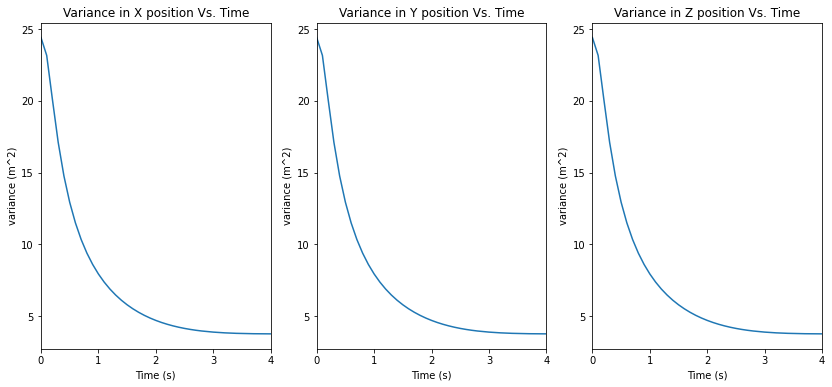

In [36]:
# Process Variances across time
fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(131)
plt.xlabel("Time (s)")
plt.ylabel("variance (m^2)")
plt.title("Variance in X position Vs. Time")
plt.xlim([0, 4])
ax1.plot(time, Ps[:,0])

ax2 = fig.add_subplot(132)
plt.xlabel("Time (s)")
plt.ylabel("variance (m^2)")
plt.title("Variance in Y position Vs. Time")
plt.xlim([0, 4])
ax2.plot(time, Ps[:,1])

ax3 = fig.add_subplot(133)
plt.xlabel("Time (s)")
plt.ylabel("variance (m^2)")
plt.title("Variance in Z position Vs. Time")
plt.xlim([0, 4])
ax3.plot(time, Ps[:,2])